# Projet Arbre de décisions - Hafadhui DANIEL

## 1. Cadrage du projet

### 1.1 Contexte et objectif du projet

Dans le cadre de ce projet, nous disposons d’une base de données recensant des projets financés par l’État, accompagnés de nombreuses informations administratives, économiques et territoriales relatives aux porteurs de projets et aux collectivités concernées.

Ces données incluent notamment des caractéristiques liées à l’entreprise (catégorie juridique, taille, activité, appartenance à l’ESS ou au statut de société à mission), à la localisation géographique (région, département, commune) ainsi qu’au type de démarche et d’axe de financement mobilisé.

L’objectif principal du projet est de modéliser le montant engagé par l’État pour financer un projet, à partir de l’ensemble de ces variables explicatives, en utilisant un modèle d’arbre de décision.
L’enjeu est double :

comprendre quels facteurs influencent le niveau de financement accordé ;

proposer un modèle interprétable, capable de fournir des règles de décision lisibles, conformément aux exigences d’une utilisation professionnelle.

### 1.2 Variable cible

La variable cible du projet est montant_engage, qui correspond au montant financier engagé par l’État pour un projet donné.

Il s’agit d’une variable quantitative continue, ce qui place naturellement le problème dans un cadre de régression supervisée.

La prédiction de cette variable présente un intérêt opérationnel important, car elle permettrait :

- d’anticiper les montants susceptibles d’être accordés à de futurs projets ;

- d’analyser les disparités de financement selon les territoires, les types de projets ou les caractéristiques des entreprises ;

- d’identifier les profils de projets associés à des financements plus élevés.

### 1.3 Méthodologie envisagée

Afin de répondre à cet objectif, nous adopterons une approche structurée inspirée des pratiques professionnelles en data science.
Le modèle principal utilisé sera un arbre de décision pour la régression, choisi pour sa capacité d’interprétation et sa pertinence dans un contexte d’aide à la décision publique.

Les étapes clés du projet seront les suivantes :

- compréhension et préparation des données (nettoyage, traitement des valeurs manquantes, encodage des variables catégorielles) ;

- séparation des données en jeux d’entraînement et de test ;

- estimation d’un modèle d’arbre de décision ;

- optimisation des hyperparamètres afin d’améliorer les performances prédictives ;

- évaluation du modèle à l’aide de métriques adaptées à la régression (RMSE, MAE, R²) ;

- interprétation des résultats à travers l’analyse de l’arbre et de l’importance des variables.

## 2 - Analyse exploratoire et visualisation des données

### 2.1 Importation des Packages

Tout d'abord, on importe les bibliothèques nécessaires. L’objectif est de disposer dès le début d’un environnement cohérent pour explorer puis nettoyer le jeu de données.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

### 2.2 - Importation des données

In [ ]:
data = pd.read_csv('data/projet.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7094 entries, 0 to 7093
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   nom_du_projet                        7094 non-null   object 
 1   resume_du_projet                     6917 non-null   object 
 2   montant_engage                       7094 non-null   float64
 3   numero_ej                            6025 non-null   float64
 4   numero_operateur                     1072 non-null   object 
 5   opérateur                            1072 non-null   object 
 6   demarche                             6962 non-null   object 
 7   nom_region                           6929 non-null   object 
 8   nom_departement                      6929 non-null   object 
 9   code_departement                     6929 non-null   object 
 10  siret_beneficiaire                   6930 non-null   float64
 11  raison_sociale_beneficiaire   

Ici nous avons fait une lecture du jeu de données pour voir la taille, les types de variables et la présence ou non de valeurs manquantes. 
On a 7094 lignes et 25 variables (la plupart sont des variables catégorielles/textuelles), avec des valeurs manquantes très importantes sur certaines.

### 2.3 - Transfomation des types

Nous allons transformer les types pour la préparation à l'encodage

In [9]:
for col in data.select_dtypes('object').columns :
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7094 entries, 0 to 7093
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   nom_du_projet                        7094 non-null   category
 1   resume_du_projet                     6917 non-null   category
 2   montant_engage                       7094 non-null   float64 
 3   numero_ej                            6025 non-null   float64 
 4   numero_operateur                     1072 non-null   category
 5   opérateur                            1072 non-null   category
 6   demarche                             6962 non-null   category
 7   nom_region                           6929 non-null   category
 8   nom_departement                      6929 non-null   category
 9   code_departement                     6929 non-null   category
 10  siret_beneficiaire                   6930 non-null   float64 
 11  raison_sociale_be

### 2.4 - Valeurs manquantes

On va voir les variables ayant des valeurs manquantes pour voir si on les supprime

In [10]:
color_palette = matplotlib.colormaps['Set2'].colors
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255))

palettehex = [rgb_to_hex(*c) for c in color_palette]

na = data.isna().sum()/data.shape[0]*100 

px.bar(na.sort_values(),
         title = "Pourcentage de valeurs manquantes par variable",
         color_discrete_sequence = palettehex[0:1],
         template='ggplot2',
         range_y = [0,100],
         width=800,
         labels={'value':'%', 'index':''},
         color=None
        ).update_traces(showlegend=False).update_xaxes(tickangle=45)

### 2.5 - Suppression des variables inutiles

Afin d’améliorer la qualité et l’interprétabilité du modèle, plusieurs variables ont été exclues de l’analyse. Les variables d’identification administrative (numéro EJ, numéro d’opérateur, SIRET) ont été supprimées car elles n’apportent aucune information explicative sur le montant engagé et peuvent conduire à un sur-apprentissage du modèle. 

De même, la variable opérateur, correspondant au nom du porteur de projet, a été écartée en raison de sa nature textuelle et de sa forte cardinalité. Les variables géographiques à un niveau très fin (commune et département) ont également été supprimées, car elles sont redondantes et peu exploitables dans un arbre de décision interprétable. 

Enfin, certaines variables présentant un taux élevé de valeurs manquantes ou un faible pouvoir informatif ont été retirées afin de renforcer la robustesse du modèle.

In [11]:
cols_to_drop = [
    "SocieteMissionUniteLegale",
    "opérateur",
    "numero_ej",
    "numero_operateur",
    "nom_departement",
    "code_departement",
    "code_commune",
    "nom_commune",
    "AnneeEffectifEtablissement",
    "siret_beneficiaire",
    "siret",
    "codePostal"
]

# Suppression des colonnes
data = data.drop(columns=cols_to_drop, errors="ignore")

print("Colonnes restantes :")
print(data.columns.tolist())

Colonnes restantes :
['nom_du_projet', 'resume_du_projet', 'montant_engage', 'demarche', 'nom_region', 'raison_sociale_beneficiaire', 'forme juridique_beneficiaire', 'activitePrincipale', 'dateCreation', 'categorieEntreprise', 'trancheEffectifsUniteLegale', 'societeMissionUniteLegale', 'etatAdministratifEtablissement', 'anneeEffectifsEtablissement', 'economieSocialeSolidaireUniteLegale']


In [12]:
for col in data.select_dtypes('object').columns :
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7094 entries, 0 to 7093
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   nom_du_projet                        7094 non-null   category
 1   resume_du_projet                     6917 non-null   category
 2   montant_engage                       7094 non-null   float64 
 3   demarche                             6962 non-null   category
 4   nom_region                           6929 non-null   category
 5   raison_sociale_beneficiaire          6956 non-null   category
 6   forme juridique_beneficiaire         6956 non-null   category
 7   activitePrincipale                   6929 non-null   category
 8   dateCreation                         6929 non-null   category
 9   categorieEntreprise                  6876 non-null   category
 10  trancheEffectifsUniteLegale          6929 non-null   category
 11  societeMissionUni

### 2.6 - Visualisation des données

Cette étape de visualisation des données a pour objectif de mieux comprendre la structure des financements publics et d’identifier les variables susceptibles d’expliquer le montant engagé par l’État. À travers différentes représentations graphiques, nous analysons la répartition du montant engagé selon des dimensions sectorielles, juridiques, économiques et territoriales. 

In [13]:
df = data.copy()

#### 2.6.A Montant engagé par secteur d’activité

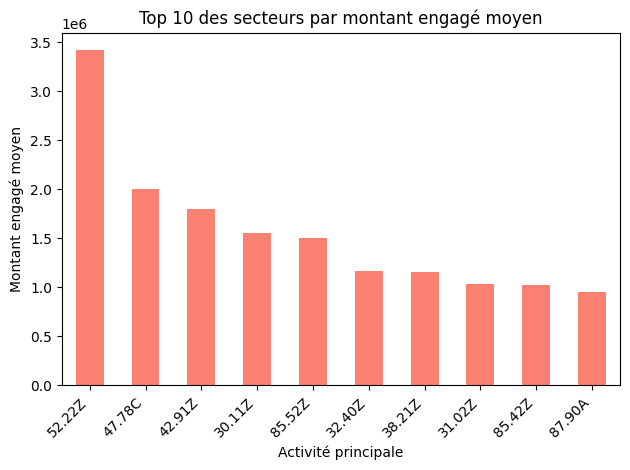

In [14]:
# Calcul de la moyenne du montant engagé par activité
montant_activite = (
    df.groupby("activitePrincipale", observed=True)["montant_engage"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

plt.figure()
montant_activite.plot(kind="bar", color="salmon")
plt.xlabel("Activité principale")
plt.ylabel("Montant engagé moyen")
plt.title("Top 10 des secteurs par montant engagé moyen")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Le premier graphique présente le top 10 des secteurs d’activité selon le montant engagé moyen. On observe une forte hétérogénéité entre les secteurs, certains bénéficiant de montants nettement plus élevés que d’autres. Les secteurs en tête correspondent généralement à des activités nécessitant des investissements importants, ce qui suggère que la nature du secteur constitue un déterminant clé du niveau de financement. Cette observation confirme la pertinence de la variable activité principale dans l’analyse explicative du montant engagé.

#### 2.6.B Montant engagé par forme juridique du bénéficiaire

C:\Users\djami\AppData\Local\Temp\ipykernel_18036\398796637.py:16: UserWarning:

Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.



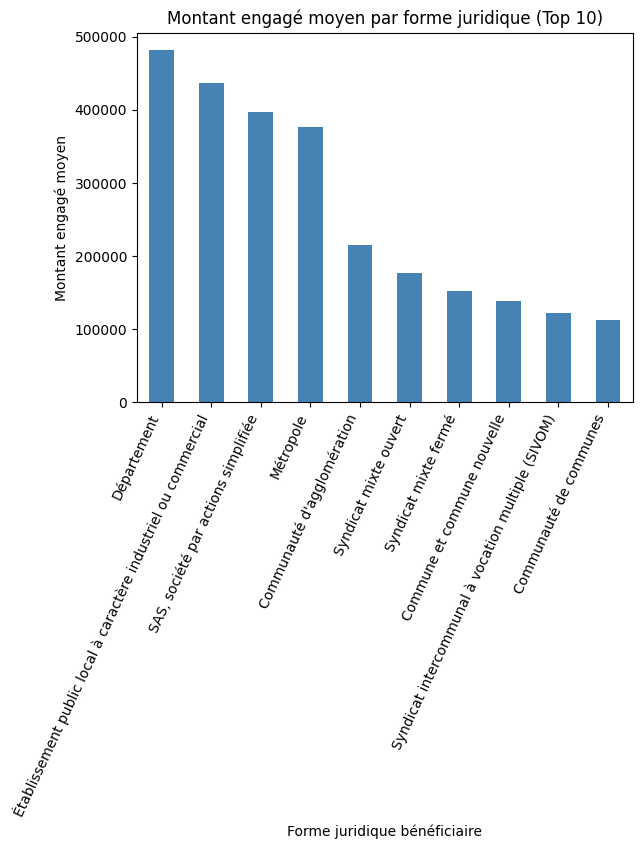

In [15]:
top_formes = df["forme juridique_beneficiaire"].value_counts().head(10).index
df_forme = df[df["forme juridique_beneficiaire"].isin(top_formes)]

montant_forme = (
    df_forme.groupby("forme juridique_beneficiaire", observed=True)["montant_engage"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
montant_forme.plot(kind="bar", color ="steelblue")
plt.xlabel("Forme juridique bénéficiaire")
plt.ylabel("Montant engagé moyen")
plt.title("Montant engagé moyen par forme juridique (Top 10)")
plt.xticks(rotation=65, ha="right")
plt.tight_layout()
plt.show()


Le graphique relatif à la forme juridique du bénéficiaire met en évidence des écarts significatifs de financement selon le type d’entité. Les départements, métropoles et établissements publics apparaissent comme les structures recevant, en moyenne, les montants les plus élevés. À l’inverse, les communes ou certaines structures intercommunales perçoivent des montants plus modestes. Ces résultats traduisent le rôle central des grandes collectivités et des établissements publics dans la mise en œuvre de projets fortement financés par l’État.

#### 2.6.C Montant engagé selon la catégorie d’entreprise

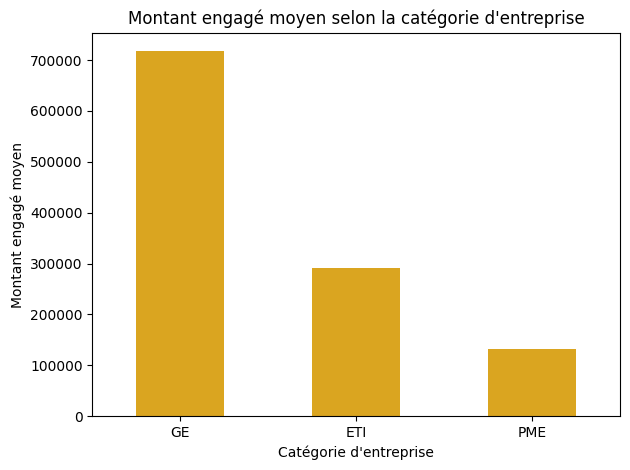

In [16]:
montant_cat = (
    df.groupby("categorieEntreprise", observed=True)["montant_engage"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
montant_cat.plot(kind="bar", color="goldenrod")
plt.xlabel("Catégorie d'entreprise")
plt.ylabel("Montant engagé moyen")
plt.title("Montant engagé moyen selon la catégorie d'entreprise")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


L’analyse par catégorie d’entreprise montre une relation claire entre la taille de l’entreprise et le montant engagé. Les grandes entreprises (GE) bénéficient en moyenne de montants nettement supérieurs à ceux accordés aux entreprises de taille intermédiaire (ETI), elles-mêmes mieux financées que les PME. Cette hiérarchie suggère que la capacité financière et organisationnelle des entreprises joue un rôle important dans l’attribution des financements publics.

#### 2.6.D Montant engagé selon la tranche d’effectifs

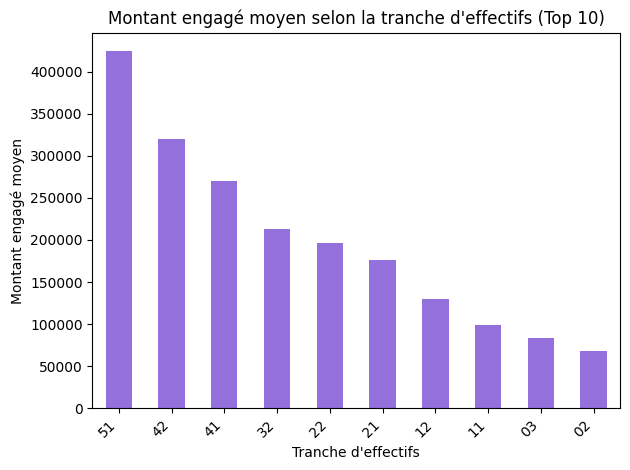

In [17]:
top_effectifs = df["trancheEffectifsUniteLegale"].value_counts().head(10).index
df_eff = df[df["trancheEffectifsUniteLegale"].isin(top_effectifs)]

montant_eff = (
    df_eff.groupby("trancheEffectifsUniteLegale", observed=True)["montant_engage"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
montant_eff.plot(kind="bar", color="mediumpurple")
plt.xlabel("Tranche d'effectifs")
plt.ylabel("Montant engagé moyen")
plt.title("Montant engagé moyen selon la tranche d'effectifs (Top 10)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Le graphique par tranche d’effectifs confirme cette tendance : plus le nombre de salariés est élevé, plus le montant engagé moyen tend à augmenter. Les structures employant plusieurs milliers de salariés reçoivent des montants significativement plus importants que les petites entités. Cette relation croissante renforce l’idée que la taille de l’organisation est un facteur explicatif majeur du niveau de financement accordé.

#### 2.6.E Montant engagé par région (moyenne)

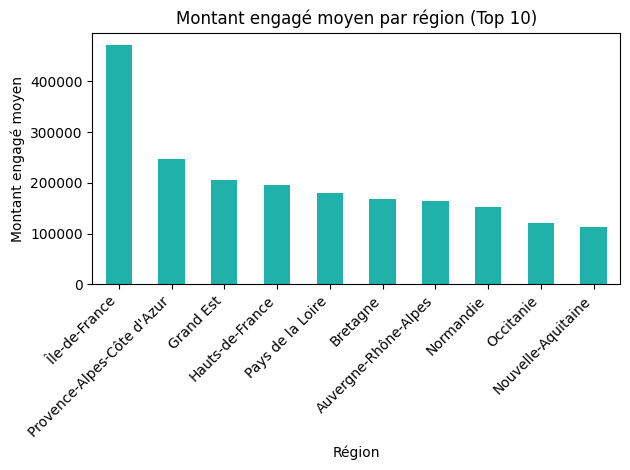

In [18]:
top_regions = df["nom_region"].value_counts().head(10).index
df_reg = df[df["nom_region"].isin(top_regions)]

montant_region = (
    df_reg.groupby("nom_region", observed=True)["montant_engage"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure()
montant_region.plot(kind="bar", color="lightseagreen")
plt.xlabel("Région")
plt.ylabel("Montant engagé moyen")
plt.title("Montant engagé moyen par région (Top 10)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


L’analyse territoriale met en évidence des disparités régionales marquées. Certaines régions, comme l’Île-de-France ou la région Provence-Alpes-Côte d’Azur, se distinguent par des montants engagés moyens plus élevés que la moyenne nationale. Ces écarts peuvent s’expliquer par la concentration de projets d’envergure, la densité économique ou encore les priorités d’investissement public selon les territoires. La région apparaît ainsi comme une variable pertinente à intégrer dans le modèle.

#### 2.6.F ESS vs non ESS

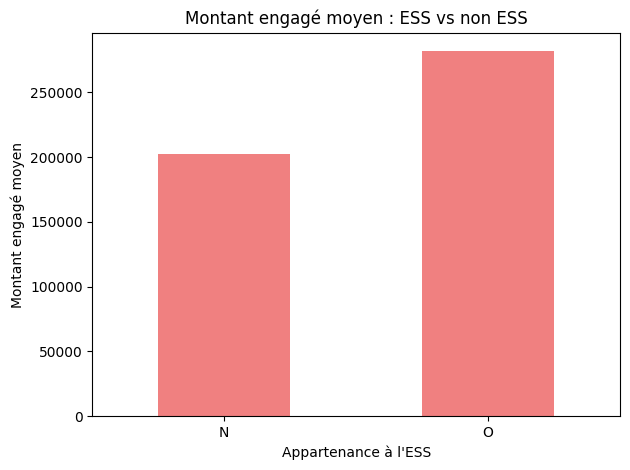

In [19]:
montant_ess = (
    df.groupby("economieSocialeSolidaireUniteLegale", observed=True)["montant_engage"]
    .mean()
)

plt.figure()
montant_ess.plot(kind="bar", color="lightcoral")
plt.xlabel("Appartenance à l'ESS")
plt.ylabel("Montant engagé moyen")
plt.title("Montant engagé moyen : ESS vs non ESS")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Enfin, la comparaison entre les structures appartenant à l’économie sociale et solidaire (ESS) et celles qui n’en relèvent pas révèle une différence notable de financement moyen. Les projets portés par des entités de l’ESS semblent bénéficier, en moyenne, de montants plus élevés. Cette observation suggère que le statut ESS peut constituer un critère différenciant dans l’attribution des financements publics.

### 2.7 - Encodage

In [20]:
# Cible en log
y = np.log1p(df["montant_engage"])

# Variables explicatives
X = df.drop(columns=["montant_engage"])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Colonnes catégorielles et numériques
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()

# Pipelines
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

# Préprocesseur complet
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_pipeline, cat_cols),
        ("num", numeric_pipeline, num_cols)
    ],
    remainder="drop"
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print("Shape X_train encodé :", X_train.shape)
print("Shape X_test encodé :", X_test.shape)


Shape X_train encodé : (5675, 16182)
Shape X_test encodé : (1419, 16182)


Avant la modélisation, la variable cible montant engagé a été transformée à l’aide d’une transformation logarithmique afin de réduire l’asymétrie de sa distribution et l’influence des valeurs extrêmes. Les données ont ensuite été séparées en variables explicatives et variable cible, puis scindées en jeux d’entraînement et de test. Les variables catégorielles ont été encodées par One-Hot Encoding et les valeurs manquantes ont été traitées par imputation simple, garantissant la robustesse et la cohérence du modèle d’arbre de décision.

## 3 - Modélisation

In [23]:
def evaluate_model_euros(model, X_test, y_test):
    """
    y_test est en log1p(montant)
    Les scores sont calculés en euros
    """

    # Prédictions (en log)
    y_pred_log = model.predict(X_test)

    # Retour en euros
    y_test_eur = np.expm1(y_test)
    y_pred_eur = np.expm1(y_pred_log)

    # Métriques en euros
    mae = mean_absolute_error(y_test_eur, y_pred_eur)
    rmse = np.sqrt(mean_squared_error(y_test_eur, y_pred_eur))
    r2 = r2_score(y_test_eur, y_pred_eur)

    print("=== Performances du modèle (en euros) ===")
    print(f"MAE  : {mae:,.2f} €")
    print(f"RMSE : {rmse:,.2f} €")
    print(f"R²   : {r2:.4f}")

    # Visualisation : vrai vs prédit
    errors = np.abs(y_test_eur - y_pred_eur)

    plt.figure()
    sc = plt.scatter(
        y_test_eur,
        y_pred_eur,
        c=errors,
        cmap="viridis",
        alpha=0.7
    )
    plt.colorbar(sc, label="Erreur absolue (€)")
    plt.xlabel("Montant réel (€)")
    plt.ylabel("Montant prédit (€)")
    plt.title("Montant réel vs montant prédit")
    plt.tight_layout()
    plt.show()


La variable cible ayant été transformée par une transformation logarithmique, l’évaluation des performances du modèle est réalisée après un retour à l’échelle initiale en euros. Les prédictions sont ainsi retranscrites dans leur unité d’origine afin de fournir des métriques interprétables. Les performances du modèle sont évaluées à l’aide du MAE, du RMSE et du coefficient de détermination R², permettant d’apprécier la précision globale du modèle et l’écart moyen entre les montants réels et prédits.

Le R², bien qu’informatif sur la variance expliquée, n’a pas été utilisé comme critère principal d’optimisation. Le choix du modèle repose principalement sur des métriques d’erreur telles que le MAE et le RMSE, plus interprétables d’un point de vue économique et mieux adaptées à l’évaluation de la précision des prédictions.

On va donc tester plusieurs modèles pour voir celui qu'on gardera pour la suite de l'analyse

### 3.1 Arbre de decision simple

Fitting 5 folds for each of 3780 candidates, totalling 18900 fits
Meilleurs hyperparamètres :
{'max_depth': 12, 'max_features': None, 'min_samples_leaf': 8, 'min_samples_split': 30}
=== Performances du modèle (en euros) ===
MAE  : 134,622.35 €
RMSE : 432,829.57 €
R²   : 0.0991


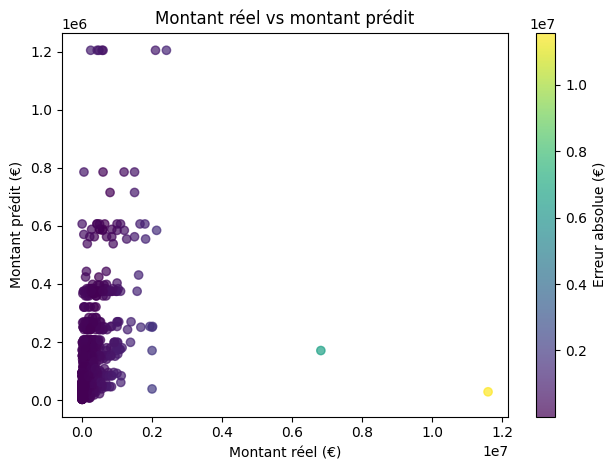

In [31]:
dt = DecisionTreeRegressor(random_state=42)

param_grid = {
    "max_depth": [None] + list(range(2, 21)),
    "min_samples_split": [2, 5, 8, 10, 12, 15, 20, 25, 30],
    "min_samples_leaf": [1, 5, 8, 10, 11, 15, 20],
    "max_features": [None, "sqrt", "log2"]
}

grid_dt = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print("Meilleurs hyperparamètres :")
print(grid_dt.best_params_)

best_dt = grid_dt.best_estimator_

evaluate_model_euros(best_dt, X_test, y_test)


### 3.2 Random Forest

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs hyperparamètres (RF) :
{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
=== Performances du modèle (en euros) ===
MAE  : 132,662.76 €
RMSE : 433,112.07 €
R²   : 0.0979


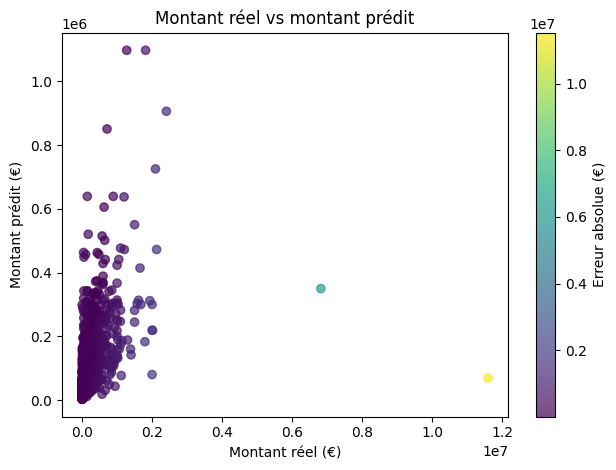

In [32]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [200, 400, 600, 800],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 10, 30],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ["sqrt", "log2", 0.5]
}

search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="neg_root_mean_squared_error",  # optimisation en log
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_rf.fit(X_train, y_train)

print("Meilleurs hyperparamètres (RF) :")
print(search_rf.best_params_)
best_rf = search_rf.best_estimator_

evaluate_model_euros(best_rf, X_test, y_test)


### 3.3 Bagging

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Meilleurs hyperparamètres (Bagging) :
{'n_estimators': 400, 'max_samples': 1.0, 'max_features': 0.6, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': None}
=== Performances du modèle (en euros) ===
MAE  : 129,019.36 €
RMSE : 423,821.43 €
R²   : 0.1362


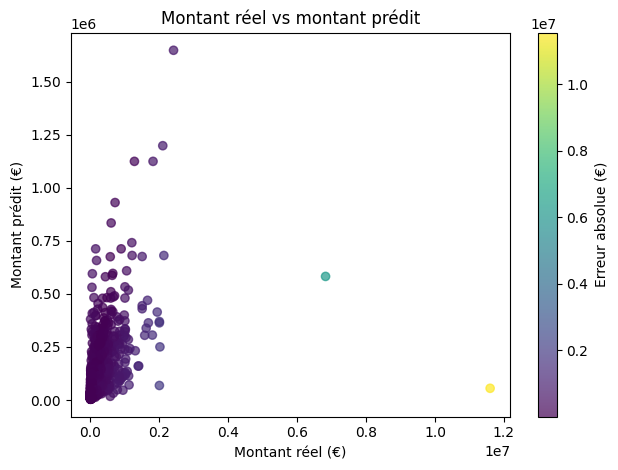

In [33]:
bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    random_state=42,
    n_jobs=-1
)

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [100, 200, 400, 600],
    "max_samples": [0.6, 0.8, 1.0],
    "max_features": [0.6, 0.8, 1.0],
    "estimator__max_depth": [10, 20, None],
    "estimator__min_samples_leaf": [1, 5, 10]
}

search_bag = RandomizedSearchCV(
    estimator=bag,
    param_distributions=param_distributions,
    n_iter=25,
    scoring="neg_root_mean_squared_error",  # optimisation en log
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_bag.fit(X_train, y_train)

print("Meilleurs hyperparamètres (Bagging) :")
print(search_bag.best_params_)

best_bag = search_bag.best_estimator_

evaluate_model_euros(best_bag, X_test, y_test)


### 3.4 Adaboost

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Meilleurs hyperparamètres (AdaBoost) :
{'n_estimators': 200, 'learning_rate': 0.05, 'estimator__min_samples_leaf': 1, 'estimator__max_depth': 5}
=== Performances du modèle (en euros) ===
MAE  : 143,866.01 €
RMSE : 445,823.71 €
R²   : 0.0442


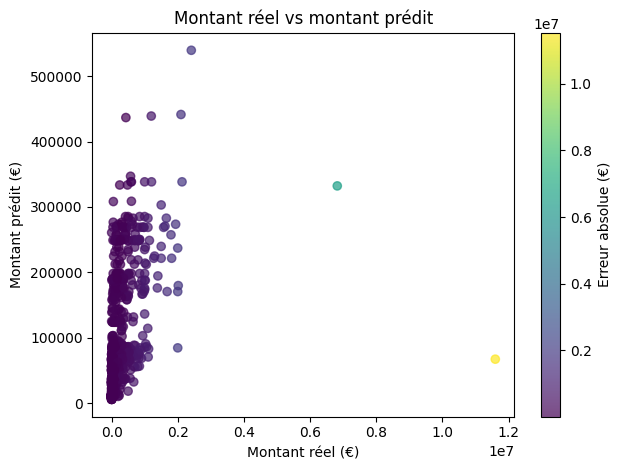

In [34]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

ada = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    random_state=42
)
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [100, 200, 400, 600],
    "learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
    "estimator__max_depth": [2, 3, 4, 5],
    "estimator__min_samples_leaf": [1, 5, 10]
}

search_ada = RandomizedSearchCV(
    estimator=ada,
    param_distributions=param_distributions,
    n_iter=25,
    scoring="neg_root_mean_squared_error",  # optimisation en log
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_ada.fit(X_train, y_train)
print("Meilleurs hyperparamètres (AdaBoost) :")
print(search_ada.best_params_)
best_ada = search_ada.best_estimator_

evaluate_model_euros(best_ada, X_test, y_test)


### 3.5 Gradientboosting

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs hyperparamètres (Gradient Boosting) :
{'subsample': 1.0, 'n_estimators': 600, 'min_samples_leaf': 5, 'max_depth': 5, 'learning_rate': 0.05}
=== Performances du modèle (en euros) ===
MAE  : 130,279.70 €
RMSE : 420,312.04 €
R²   : 0.1504


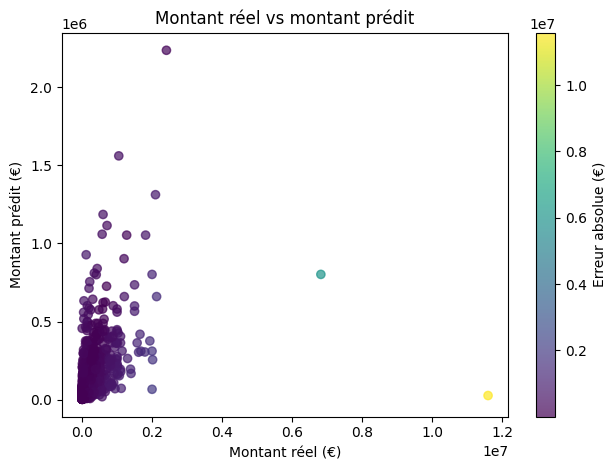

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)

from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [200, 400, 600, 800],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5],
    "min_samples_leaf": [1, 5, 10, 20],
    "subsample": [0.6, 0.8, 1.0]
}

search_gbr = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="neg_root_mean_squared_error",  # optimisation en log
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_gbr.fit(X_train, y_train)

print("Meilleurs hyperparamètres (Gradient Boosting) :")
print(search_gbr.best_params_)
best_gbr = search_gbr.best_estimator_

evaluate_model_euros(best_gbr, X_test, y_test)


### 3.6 XGBoost

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Meilleurs hyperparamètres (XGBoost) :
{'subsample': 0.6, 'reg_lambda': 10, 'n_estimators': 900, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
=== Performances du modèle (en euros) ===
MAE  : 129,196.67 €
RMSE : 420,436.33 €
R²   : 0.1499


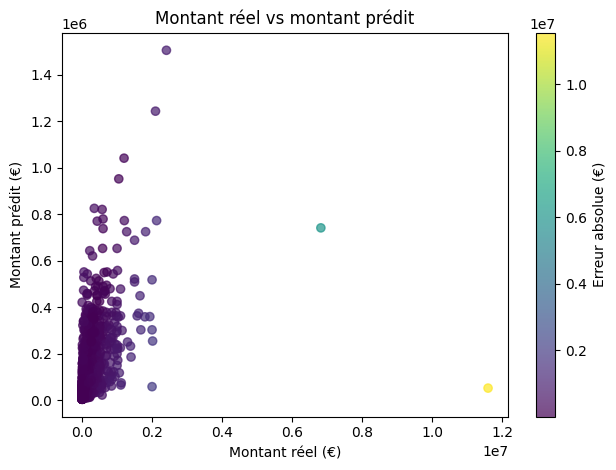

In [37]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "n_estimators": [300, 600, 900, 1200],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "max_depth": [3, 4, 5, 6, 8],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "reg_lambda": [1, 5, 10]
}

search_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=30,
    scoring="neg_root_mean_squared_error",  # optimisation en log
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

search_xgb.fit(X_train, y_train)
print("Meilleurs hyperparamètres (XGBoost) :")
print(search_xgb.best_params_)
best_xgb = search_xgb.best_estimator_

evaluate_model_euros(best_xgb, X_test, y_test)


## 4 - Meilleur Modèle

### 4.1 Tableau comparatif

In [3]:
# Tableau des résultats
results_df = pd.DataFrame({
    "Modèle": [
        "Arbre de décision",
        "Random Forest",
        "Bagging",
        "AdaBoost",
        "Gradient Boosting",
        "XGBoost"
    ],
    "MAE (€)": [
        134622.35,
        132662.76,
        129019.36,
        143866.01,
        130279.70,
        129196.67
    ],
    "RMSE (€)": [
        432829.57,
        433112.07,
        423821.43,
        445823.71,
        420312.04,
        420436.33
    ],
    "R²": [
        0.0991,
        0.0979,
        0.1362,
        0.0442,
        0.1504,
        0.1499
    ]
})

results_df = results_df.sort_values("RMSE (€)", ascending=True).reset_index(drop=True)

results_df


,Modèle,MAE (€),RMSE (€),R²
0,Gradient Boosting,130279.70,420312.04,0.1504
1,XGBoost,129196.67,420436.33,0.1499
2,Bagging,129019.36,423821.43,0.1362
3,Arbre de décision,134622.35,432829.57,0.0991
4,Random Forest,132662.76,433112.07,0.0979
5,AdaBoost,143866.01,445823.71,0.0442


Plusieurs modèles de régression ont été testés et comparés afin d’identifier celui offrant les meilleures performances prédictives. Les résultats montrent que les méthodes de boosting surpassent globalement les modèles plus simples. Parmi elles, le Gradient Boosting Regressor se distingue par le plus faible RMSE et le R² le plus élevé, traduisant une meilleure capacité à prédire les montants engagés tout en limitant les erreurs importantes. Ce modèle a donc été retenu comme modèle final pour la suite de l’analyse.

### 4.2 Modélisation du meilleur modèle

In [21]:
final_gbr = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    min_samples_leaf=5,
    subsample=1.0,
    random_state=42
)

final_gbr.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,600
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


=== Performances du modèle (en euros) ===
MAE  : 130,279.70 €
RMSE : 420,312.04 €
R²   : 0.1504


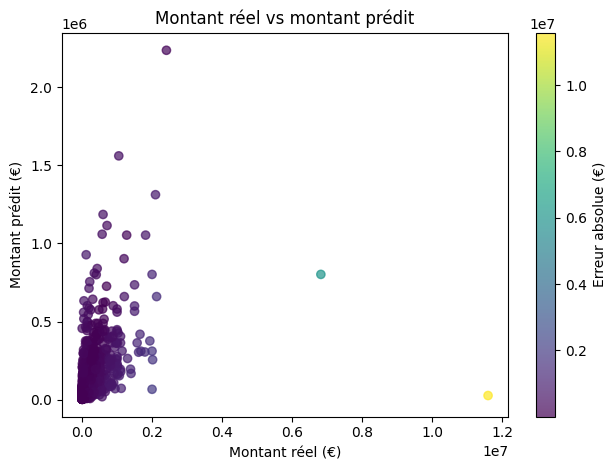

In [24]:
evaluate_model_euros(final_gbr, X_test, y_test)


In [25]:
feature_names = preprocessor.get_feature_names_out()


In [26]:
importances = pd.DataFrame({
    "Variable": feature_names,
    "Importance": final_gbr.feature_importances_
})

importances = importances.sort_values("Importance", ascending=False)
importances.head(15)

,Variable,Importance
10814,cat__demarche_Rénovation des parcs de luminair...,0.176760
16161,cat__categorieEntreprise_PME,0.093015
10815,cat__demarche_Rénovation énergétique des bâtim...,0.084210
10809,cat__demarche_Prévention des risques d’incendi...,0.079937
10810,cat__demarche_Recyclage foncier,0.077383
10808,cat__demarche_Ingénierie,0.046246
10817,cat__demarche_Territoires d'Industrie en trans...,0.032748
10807,cat__demarche_Développement du covoiturage,0.026299
16163,cat__trancheEffectifsUniteLegale_02,0.026040
10839,cat__nom_region_Île-de-France,0.018210


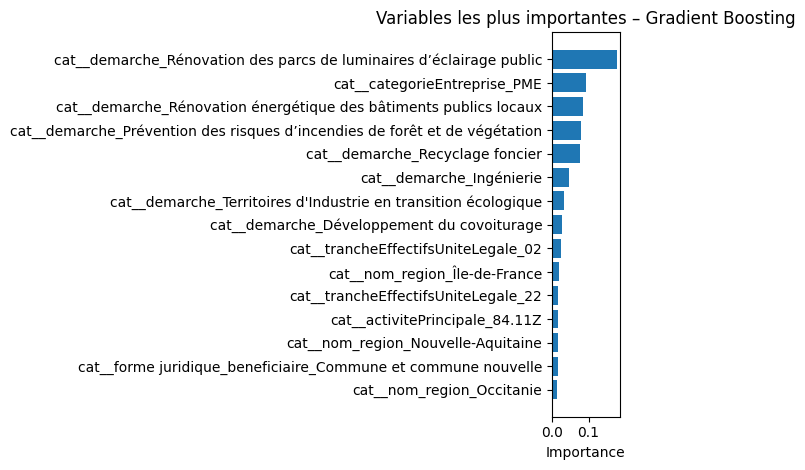

In [28]:
top_features = importances.head(15)

plt.figure()
plt.barh(top_features["Variable"], top_features["Importance"])
plt.xlabel("Importance")
plt.title("Variables les plus importantes – Gradient Boosting")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Interprétation du modèle de Gradient Boosting

L’analyse des importances de variables issues du modèle de Gradient Boosting permet d’identifier les facteurs jouant un rôle déterminant dans la prédiction du montant engagé par l’État. Les résultats montrent que le modèle s’appuie principalement sur des variables liées au type de démarche financée, aux caractéristiques des bénéficiaires et, dans une moindre mesure, à la localisation géographique.

La variable la plus importante du modèle correspond à la démarche “Rénovation des parcs de luminaires d’éclairage public”, qui concentre à elle seule une part significative de l’importance totale. D’autres démarches, telles que la rénovation énergétique des bâtiments publics locaux, la prévention des risques d’incendies de forêt ou encore le recyclage foncier, figurent également parmi les variables les plus influentes.

Ces résultats indiquent que le type de projet financé constitue le premier déterminant du montant engagé, certaines démarches impliquant structurellement des investissements plus élevés que d’autres. Cette observation est cohérente avec la logique des politiques publiques, où les projets d’infrastructures ou de transition écologique nécessitent des montants plus importants.

Parmi les variables explicatives majeures figurent également des caractéristiques liées aux bénéficiaires des financements. La catégorie d’entreprise PME apparaît comme une variable importante, suggérant que le profil du porteur de projet influe sur le niveau de financement accordé. De même, certaines tranches d’effectifs salariés contribuent significativement à la prédiction, traduisant l’impact de la taille de la structure sur les montants engagés.

La forme juridique du bénéficiaire, notamment le statut de commune ou de collectivité, ressort également dans les variables importantes, ce qui reflète le rôle central des collectivités territoriales dans la mise en œuvre de projets financés par l’État.

Enfin, plusieurs variables géographiques, telles que l’appartenance à des régions comme l’Île-de-France, la Nouvelle-Aquitaine ou l’Occitanie, apparaissent parmi les variables explicatives, bien que leur importance reste plus modérée. Cela suggère l’existence de disparités territoriales dans les montants engagés, sans pour autant que la région constitue le facteur principal de décision.

## 5. Conclusion

Ce projet avait pour objectif de prédire le montant engagé par l’État dans le financement de projets publics à partir de caractéristiques administratives, économiques et territoriales. Après une phase de préparation des données et d’analyse exploratoire, plusieurs modèles de régression ont été estimés et comparés, allant de l’arbre de décision simple à des méthodes d’ensemble plus avancées. Les résultats montrent que les modèles de boosting, et en particulier le Gradient Boosting Regressor, offrent les meilleures performances en termes de précision et de capacité explicative. L’analyse des importances de variables met en évidence le rôle central du type de démarche financée, des caractéristiques du bénéficiaire et, dans une moindre mesure, de la localisation géographique. Ces résultats confirment la pertinence de l’approche retenue et l’intérêt des méthodes d’apprentissage supervisé pour l’analyse des mécanismes de financement public.